In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
from sklearn.linear_model import LinearRegression
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [2]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

In [3]:
n_clusters=1000
f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [5]:
delay = int(.75*frameRate)
print(delay)
# delay=13
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
final_labels = op_calc.get_connected_labels(labels_traj,lcs)
n_modes=10
inv_measure = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)

eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi2 = eigfunctions[:,1]

12


2


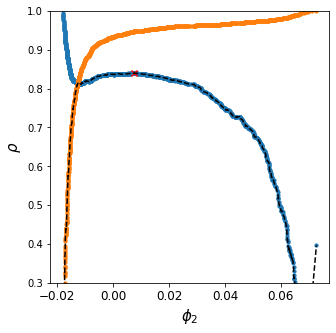

1
1 [0.9058013610201544, 0.7152434371969072] [0.24603384630523925, 0.7539661536947606]
3


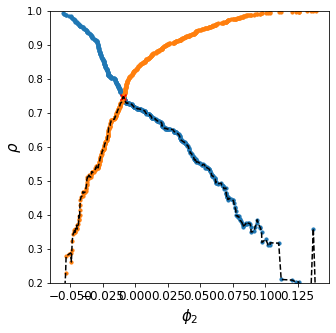

2
2 [0.9058013610201552, 0.7883942955089343, 0.6396220993332441] [0.24603384630523925, 0.3650905346776207, 0.38887561901713996]
4


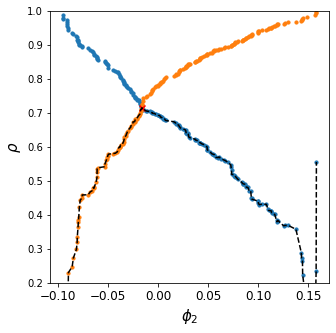

3
1 [0.9058013610201553, 0.788394295508933, 0.7184722201985206, 0.5823284967763378] [0.24603384630523925, 0.3650905346776207, 0.21029300686454677, 0.17858261215259313]
5


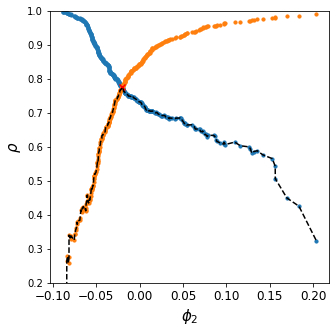

4
0 [0.905801361020156, 0.7184722201985209, 0.5823284967763379, 0.7362340481140033, 0.706276681085514] [0.24603384630523925, 0.21029300686454677, 0.17858261215259313, 0.1484855749046222, 0.2166049597729985]
6


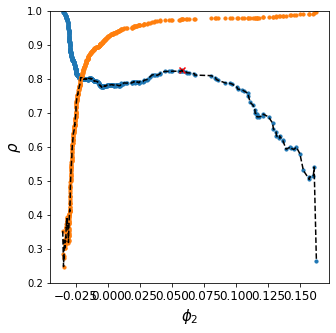

5
5 [0.7184722201985213, 0.5823284967763371, 0.7362340481140033, 0.7062766810855142, 0.8516908473506537, 0.7609160440695083] [0.21029300686454677, 0.17858261215259313, 0.1484855749046222, 0.2166049597729985, 0.019472852572137045, 0.2265609937331022]
8


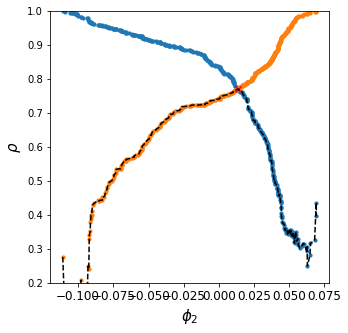

In [6]:
n_final_states=6
labels_tree = op_calc.recursive_partitioning_optimal(final_labels,delay,phi2,inv_measure,R,n_final_states,plot=True)

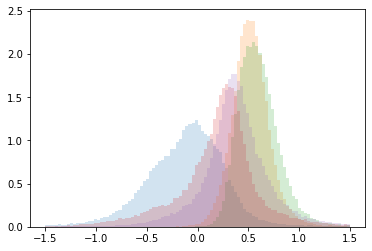

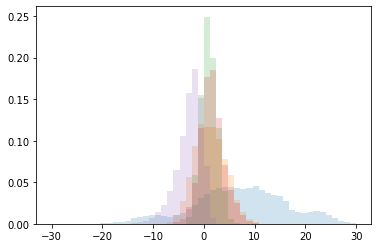

In [7]:
n_states = 5
kmeans_labels = labels_tree[n_states-2,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

for state_idx in range(n_states):
    plt.hist(omegas_all[cluster_traj==state_idx].compressed(),bins=100,range=[-1.5,1.5],alpha=.2,density=True)
plt.show()
for state_idx in range(n_states):
    plt.hist(a3s_all[cluster_traj==state_idx].compressed(),bins=50,range=[-30,30],alpha=.2,density=True)
plt.show()

data_lifetimes = stats.state_lifetime(cluster_traj[::delay],delay*dt)

In [4]:
worms = np.arange(len(tseries_w))
len_w = len(tseries_w[0])
ensemble_labels_w=[]
for worm in worms:
    ensemble_labels_w.append(labels_traj[len_w*worm:len_w*(worm+1)])

In [5]:
sims_w = []
f = h5py.File(dir_path+'Foraging/ForagingData/symbol_sequence_simulations.h5','r')
for worm in worms:
    sims = np.array(f['{}/sims'.format(worm)],dtype=int)
    sims_w.append(sims)
f.close()

In [11]:
from scipy.optimize import curve_fit

def get_lifetimes(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay):
    labels = ensemble_labels_w[worm]
    sims = sims_w[worm]

    cluster_labels = labels_tree[n_states-2,:]
    sims_lifetimes = [stats.state_lifetime(ma.array(cluster_labels[sim]),delay*dt) for sim in sims]
    
    cluster_traj = ma.copy(labels)
    cluster_traj[~labels.mask] = ma.array(cluster_labels)[labels[~labels.mask]]
    cluster_traj[labels.mask] = ma.masked

    data_lifetimes = stats.state_lifetime(cluster_traj[::delay],delay*dt)

    x_sim_state = []
    y_sim_state = []
    for state_idx in range(n_states):
        max_state_sim=np.max(np.hstack([sims_lifetimes[k][state_idx] for k in range(n_states)]))
        max_state_data=np.max(np.hstack([data_lifetimes[state_idx] for k in range(n_states)]))
        max_state = np.max([max_state_sim,max_state_data])
        x_sim = []
        y_sim = []
        for sim_lifetime in sims_lifetimes:
            if len(sim_lifetime)==n_states:
                x,y = stats.cumulative_dist(sim_lifetime[state_idx],[0,2*max_state])
                y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
                x = np.sort(np.unique(x))
                if ~np.any(np.isnan(y)):
                    x_sim.append(x)
                    y_sim.append(y)
        x_sim_state.append(x_sim)
        y_sim_state.append(y_sim)
    return x_sim_state,y_sim_state,sims_lifetimes,data_lifetimes

def bootstrap_timescales(state_idx,x_sim_state,y_sim_state,ci=95):
    per = (100-ci)/2
    
    
    x_sim = x_sim_state[state_idx]
    y_sim = y_sim_state[state_idx]

    all_x = np.sort(np.unique(np.hstack(x_sim)))
    min_x = np.min(all_x)
    max_x = np.max(all_x)
    step = np.diff(all_x)[0]
    x_all = np.arange(min_x,max_x+step,step)

    y_counts = []
    for x in x_all:
        y_count_sim = []
        for sim_idx in range(len(x_sim)):
            x_here = x_sim[sim_idx]
            y_here = y_sim[sim_idx]
            sel = x_here == x
            y_count_sim.append(y_here[sel])
        y_counts.append(np.hstack(y_count_sim))
        
    y_bs = ma.zeros((len(x_all),3))
    for ky,y in enumerate(y_counts):
        if len(y)>0:
            mean = np.mean(y)
            y_bs[ky] = [mean,np.percentile(y,per),np.percentile(y,100-per)]
    y_bs[y_bs == 0] = ma.masked
    y_bs[1:,:][y_bs[1:,:]==0] = ma.masked
    y_bs[y_bs[:,1]<1e-5,1] = ma.masked
    
    return x_all,1-y_bs

In [12]:
def plot_timescales(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay,colored=True):
    x_sim_state,y_sim_state,sims_lifetimes,data_lifetimes = get_lifetimes(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay)
    max_state=5000
    plt.figure(figsize=(5,4*n_states))
    for state_idx in range(n_states):
        if data_lifetimes[state_idx].shape[0]>5:
            ax = plt.subplot(n_states,1,state_idx+1)
            plt.title(state_idx)
            x_all,y_bs = bootstrap_timescales(state_idx,x_sim_state,y_sim_state)
            x,y = stats.complementary_cumulative_dist(data_lifetimes[state_idx],[0,2*max_state])
            y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
            x = np.sort(np.unique(x))

            if colored:
                plt.plot(x_all,y_bs[:,0],c=colors_state_[state_idx],alpha=1)
                plt.fill_between(x_all,y_bs[:,1],y_bs[:,2],alpha=.5,color=colors_state_[state_idx])
            else:
                plt.plot(x_all,y_bs[:,0],c='k',alpha=1)
                plt.fill_between(x_all,y_bs[:,1],y_bs[:,2],alpha=.5,color='k')
            plt.plot(x[y>0],y[y>0],c='k',lw=3,ls='--')



            plt.yscale('log',nonpositive='clip')
            
            ax.set_ylim(bottom=1e-3)
            print(y[y>0].min(),y_bs[:,0][y_bs[:,0]>0].min())
            plt.ylim(np.min(y[y>0]),1)            
            print([x[y>0].max(),x_all[ma.filled(y_bs[:,0]>0,False)].max()])
            plt.xlim(x.min(),np.max([x[y>0].max(),x_all[ma.filled(y_bs[:,0]>0,False)].max()])*1.1)
            plt.ylabel('P',fontsize=14)
            plt.xlabel('t (s)',fontsize=14)
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
    plt.tight_layout()


0.005586592178770999 0.0003992015968063978
[9.75, 18.0]
0.005586592178770999 0.0005988023952095967
[65.25, 69.0]


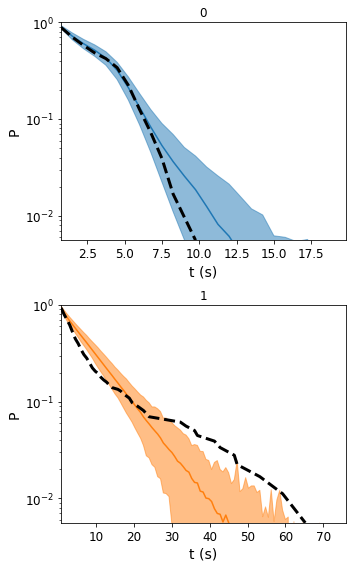

0.0050505050505050275 0.00044802867383508804
[15.0, 21.75]
0.010101010101010055 0.000764525993883769
[140.25, 172.5]


<Figure size 432x288 with 0 Axes>

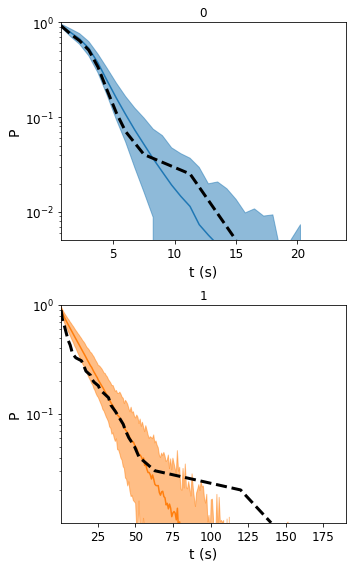

0.008196721311475419 0.00029197080291964994
[20.25, 48.75]
0.008196721311475419 0.00046992481203012026
[84.0, 101.25]


<Figure size 432x288 with 0 Axes>

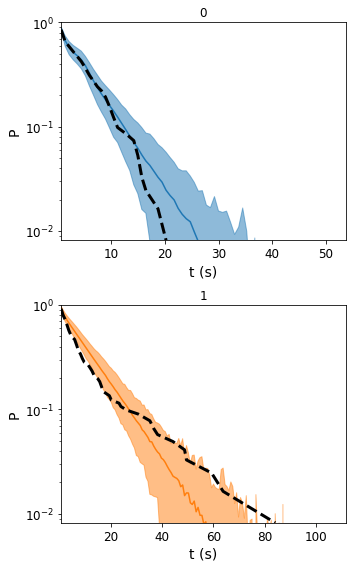

0.010204081632653073 0.0005952380952380931
[12.0, 18.75]
0.010101010101010055 0.0007374631268436405
[87.75, 141.0]


<Figure size 432x288 with 0 Axes>

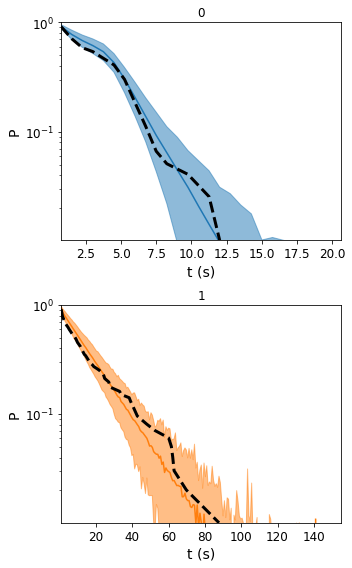

0.009433962264150941 0.00042735042735042583
[21.75, 32.25]
0.00952380952380949 0.0007122507122507837
[92.25, 152.25]


<Figure size 432x288 with 0 Axes>

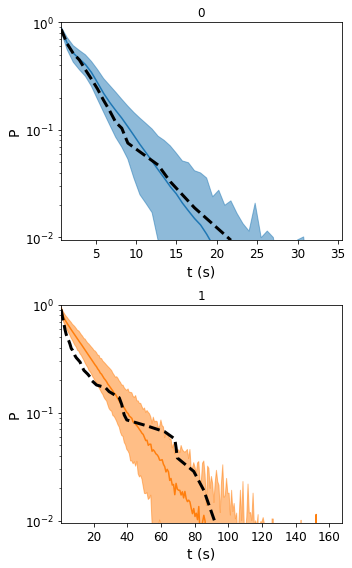

0.007692307692307665 0.0005602240896358524
[36.75, 53.25]
0.007751937984496138 0.0008689040947105209
[51.75, 81.0]


<Figure size 432x288 with 0 Axes>

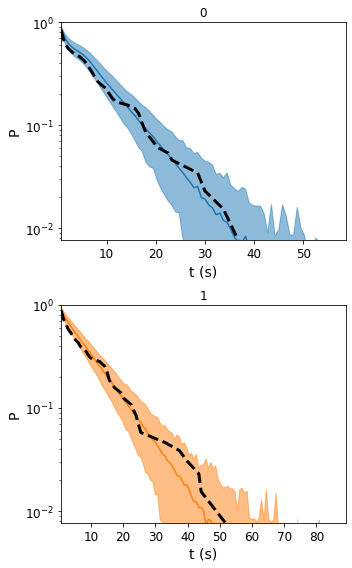

0.010204081632653073 0.0004448136094807875
[24.75, 38.25]
0.01041666666666663 0.0008417508417508657
[126.0, 124.5]


<Figure size 432x288 with 0 Axes>

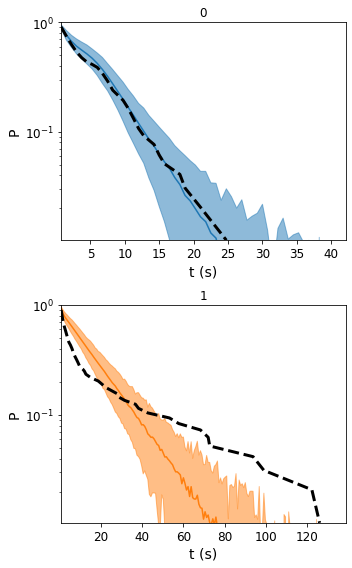

0.011627906976744207 0.0005952380952380931
[16.5, 27.75]
0.011627906976744207 0.0008680555555554692
[90.75, 141.0]


<Figure size 432x288 with 0 Axes>

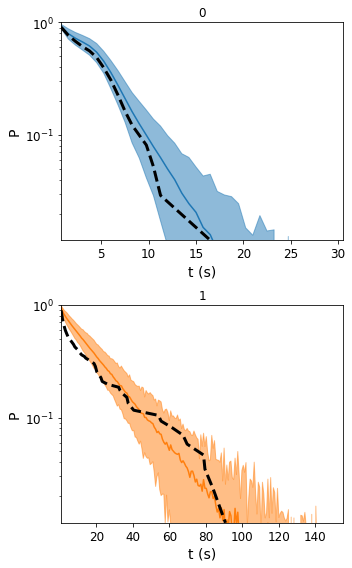

0.0040983606557377095 0.0001831501831501825
[15.0, 23.25]
0.008196721311475419 0.0005681818181817455
[92.25, 125.25]


<Figure size 432x288 with 0 Axes>

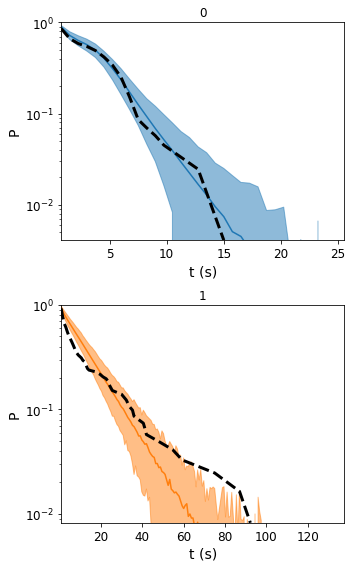

0.011494252873563204 0.000234082397003732
[17.25, 24.0]
0.011494252873563204 0.001162790697674554
[139.5, 156.0]


<Figure size 432x288 with 0 Axes>

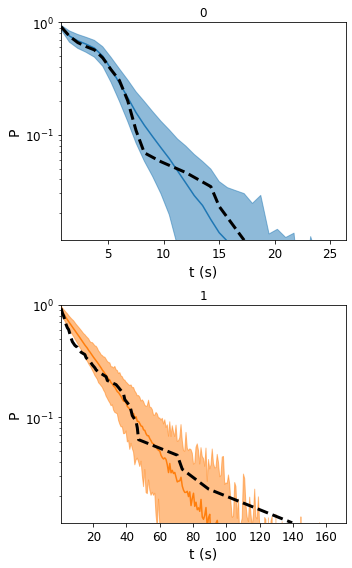

0.00990099009900991 0.0005096839959226607
[18.75, 24.0]
0.009708737864077666 0.0009372071227741197
[66.75, 139.5]


<Figure size 432x288 with 0 Axes>

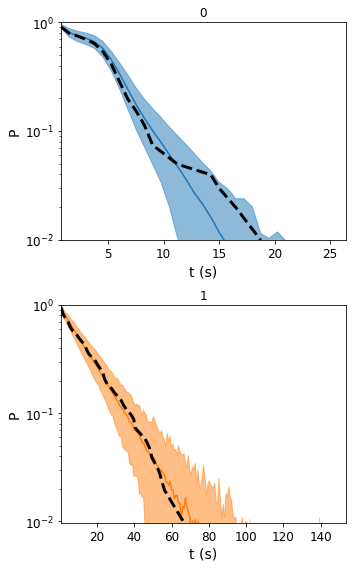

0.016949152542372836 0.00028232636928282595
[9.75, 32.25]
0.016393442622950838 0.0017482517482517723
[106.5, 192.0]


<Figure size 432x288 with 0 Axes>

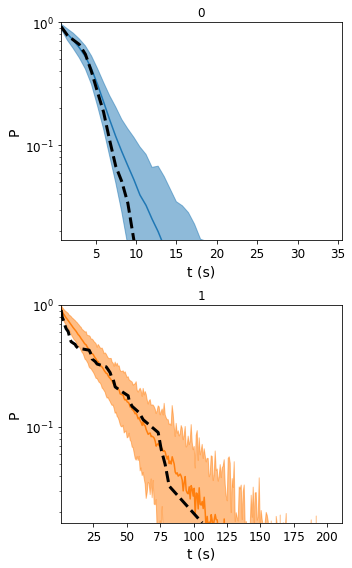

<Figure size 432x288 with 0 Axes>

In [13]:
n_states = 2
for worm in worms:
    plot_timescales(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay)
#     plt.savefig('tscales_{}_states_worm_{}_subfigures.pdf'.format(n_states,worm))
    plt.show()
    plt.clf()

0.005586592178770999 0.0003992015968063978
[9.75, 18.0]
0.003816793893129722 0.00010611205432942139
[5.25, 9.75]
0.0023474178403755652 7.43273375947151e-05
[6.75, 9.0]
0.007194244604316539 0.0001240147896681698
[4.5, 7.5]
0.0034364261168384758 0.0002722139875067642
[6.0, 10.5]


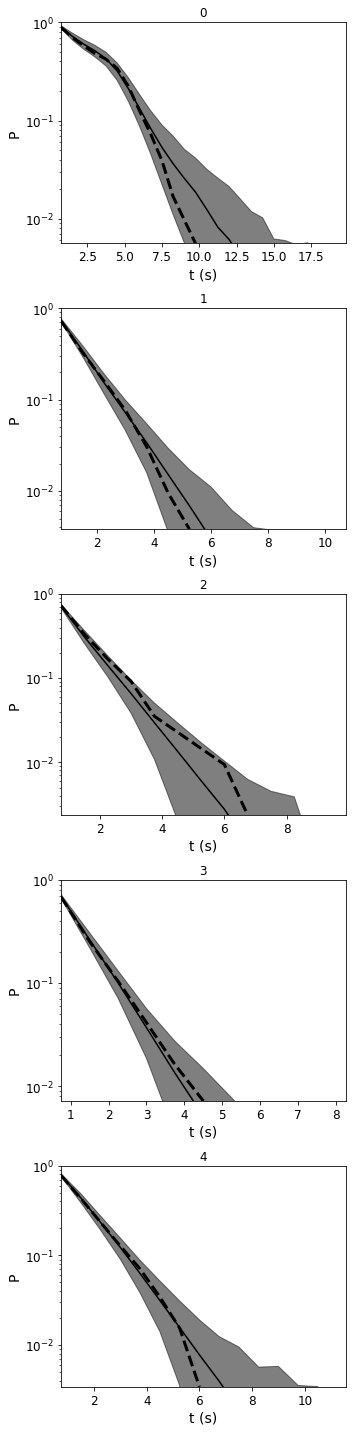

0
0.0050505050505050275 0.00044802867383508804
[15.0, 21.75]
0.002949852507374673 0.00014636295882586303
[15.0, 14.25]
0.003816793893129722 0.00022313259269834962
[7.5, 10.5]
0.024193548387096753 8.865248226952449e-05
[4.5, 9.75]
0.002994011976047928 0.0003904494382022117
[8.25, 11.25]


<Figure size 432x288 with 0 Axes>

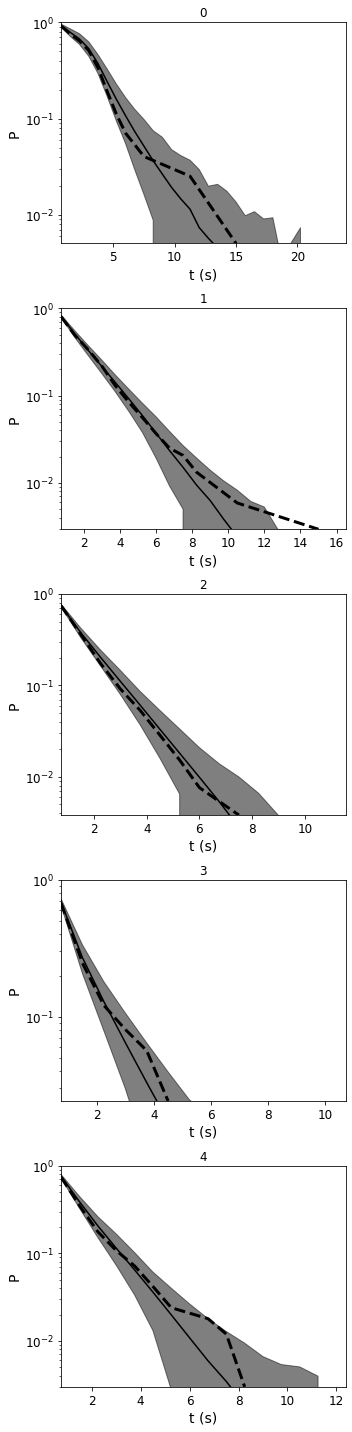

1
0.008196721311475419 0.00029197080291964994
[20.25, 48.75]
0.00295857988165682 0.0006242472212711903
[3.75, 5.25]
0.002450980392156854 8.348149917292158e-05
[5.25, 8.25]
0.0036363636363636598 4.609994468007805e-05
[6.75, 9.75]
0.004184100418409997 0.00014827995255040083
[7.5, 14.25]


<Figure size 432x288 with 0 Axes>

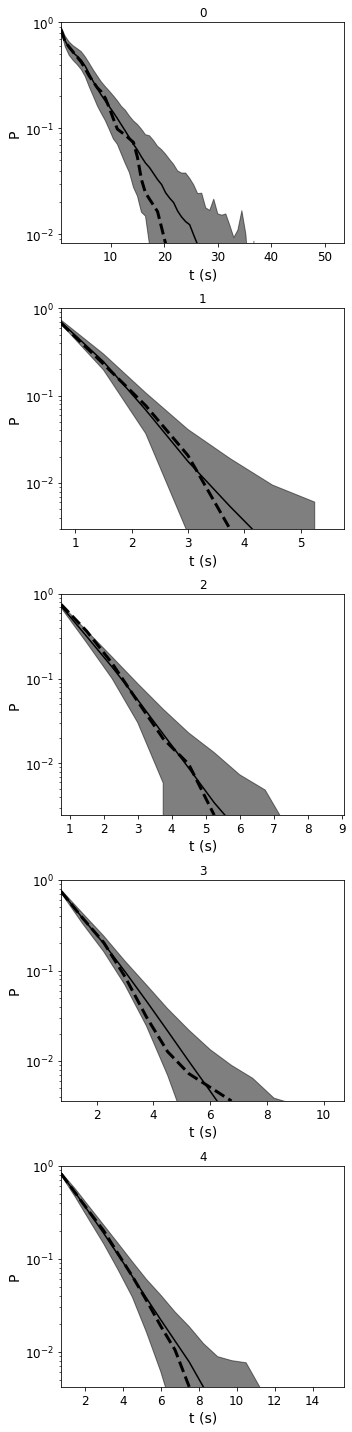

2
0.010204081632653073 0.0005952380952380931
[12.0, 18.75]
0.002392344497607668 4.608294930874557e-05
[3.0, 5.25]
0.003236245954692518 6.066488716338636e-05
[6.75, 9.75]
0.0052631578947368585 6.654245408566073e-05
[4.5, 6.75]
0.007204610951008661 0.0001456862971961348
[6.0, 11.25]


<Figure size 432x288 with 0 Axes>

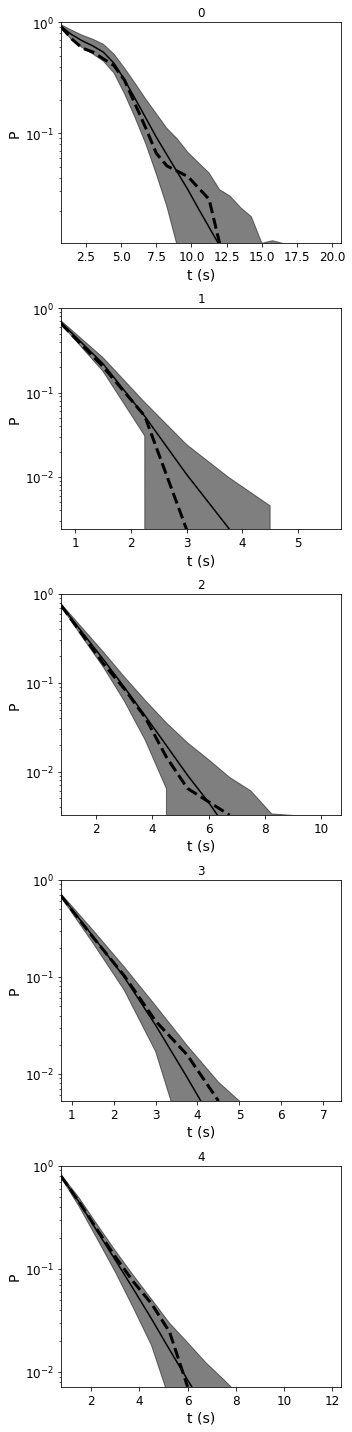

3
0.009433962264150941 0.00042735042735042583
[21.75, 32.25]
0.004830917874396157 6.0672248513471416e-05
[5.25, 7.5]
0.0035460992907800915 0.00010486577181212375
[6.0, 10.5]
0.0033670033670033517 0.00016109352552440281
[6.75, 9.75]
0.006430868167202582 9.891196834810323e-05
[7.5, 13.5]


<Figure size 432x288 with 0 Axes>

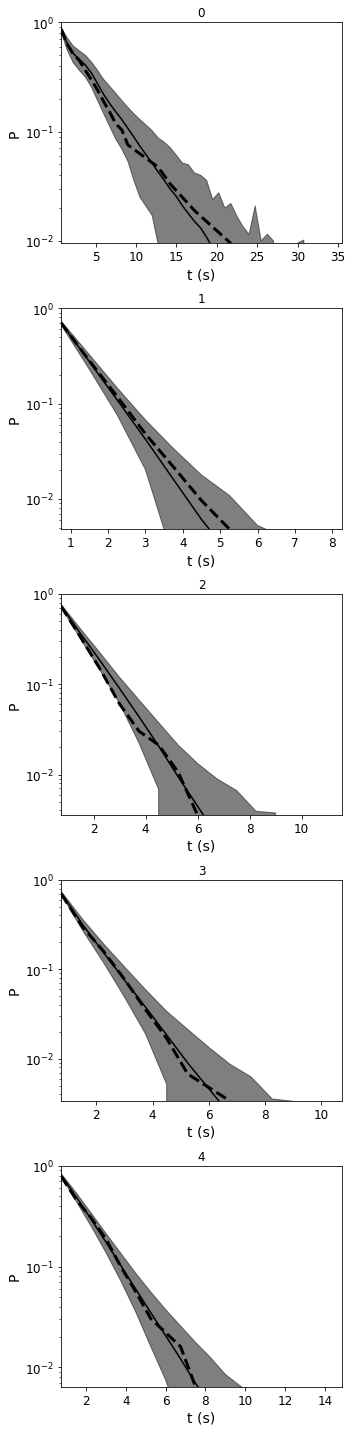

4
0.007692307692307665 0.0005602240896358524
[36.75, 53.25]
0.04597701149425288 0.0010900542036132999
[2.25, 6.0]
0.021978021978021973 0.0004086509376890479
[3.0, 6.0]
0.0019607843137254832 0.00026096681772747043
[6.75, 12.75]
0.004545454545454519 8.157937673358706e-05
[9.75, 16.5]


<Figure size 432x288 with 0 Axes>

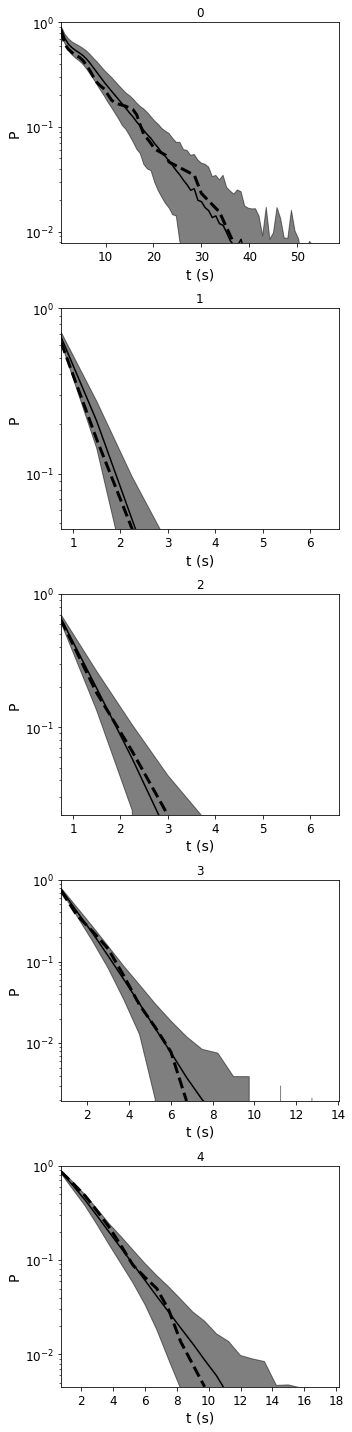

5
0.010204081632653073 0.0004448136094807875
[24.75, 38.25]
0.0013586956521738913 5.3763440860166156e-05
[11.25, 16.5]
0.0025510204081632404 0.0003841474783687904
[3.75, 5.25]
0.005434782608695676 0.00014051407588733245
[3.0, 6.0]
0.0039215686274509665 0.0002591742066585523
[7.5, 10.5]


<Figure size 432x288 with 0 Axes>

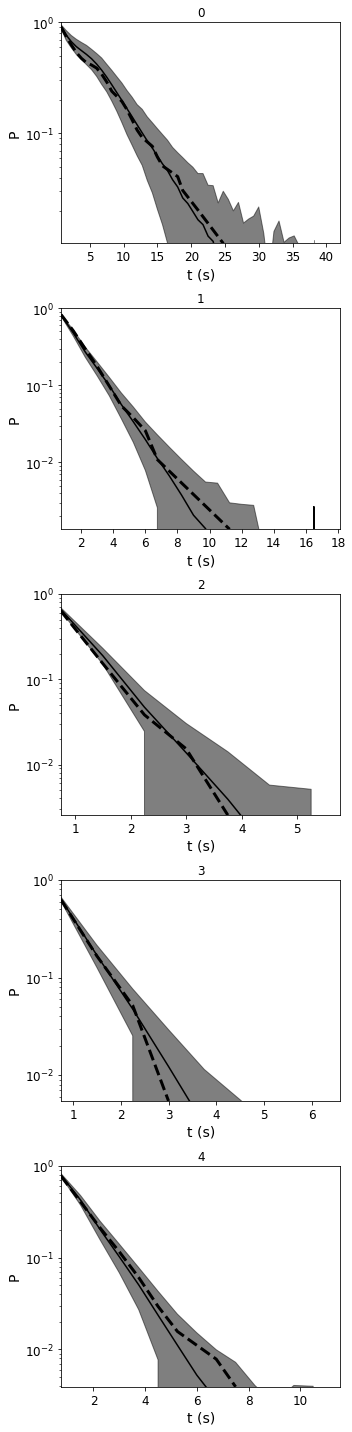

6
0.011627906976744207 0.0005952380952380931
[16.5, 27.75]
0.0019305019305019266 0.00020570931299557227
[28.5, 38.25]
0.016556291390728468 0.0001614987080102992
[3.0, 7.5]
0.010000000000000009 0.00017746228926351915
[4.5, 6.75]
0.017241379310344824 8.928571428568066e-05
[4.5, 8.25]


<Figure size 432x288 with 0 Axes>

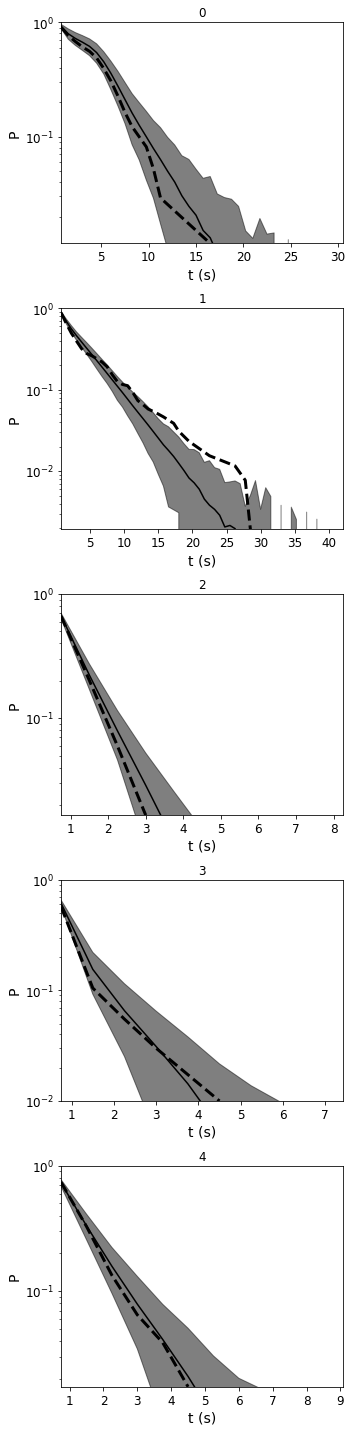

7
0.0040983606557377095 0.0001831501831501825
[15.0, 23.25]
0.0034364261168384758 0.00015990175108904214
[6.0, 7.5]
0.005102040816326536 0.00011603620329547759
[6.75, 8.25]
0.010830324909747313 0.00017765993677343328
[3.0, 5.25]
0.003076923076923088 8.499065102829384e-05
[6.75, 9.75]


<Figure size 432x288 with 0 Axes>

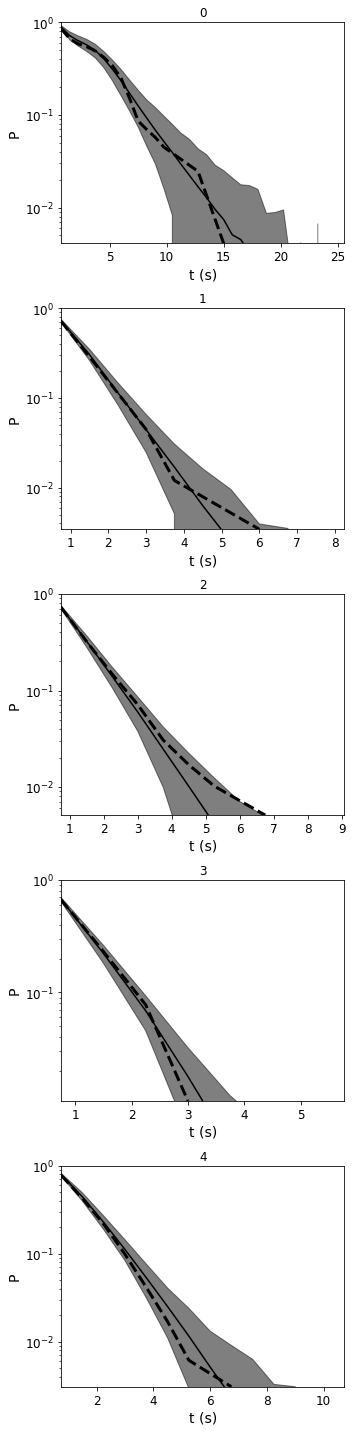

8
0.011494252873563204 0.000234082397003732
[17.25, 24.0]
0.007352941176470562 9.09725425136676e-05
[5.25, 6.75]
0.004950495049504955 0.00023178294418402245
[6.75, 9.75]
0.003225806451612856 0.00017740450118597373
[7.5, 9.75]
0.0031847133757961776 7.504690431525685e-05
[6.75, 12.0]


<Figure size 432x288 with 0 Axes>

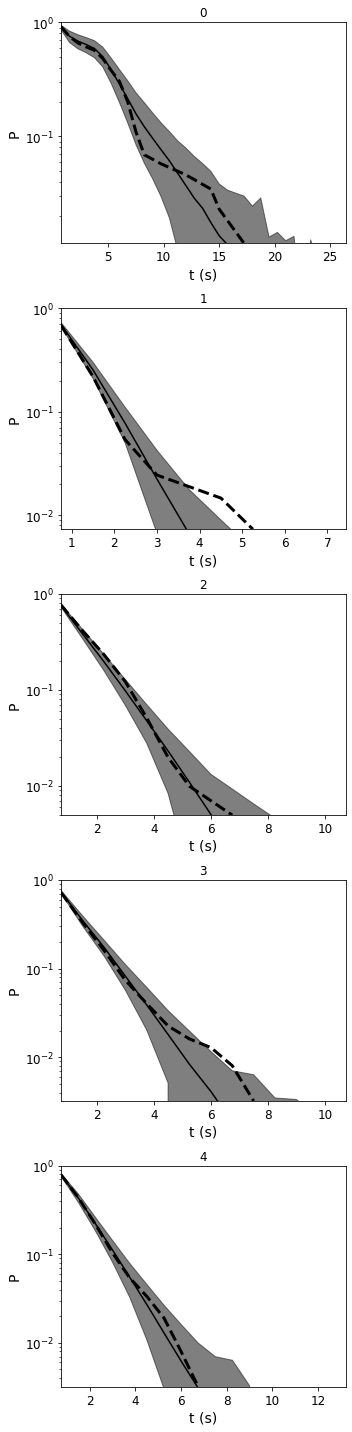

9
0.00990099009900991 0.0005096839959226607
[18.75, 24.0]
0.005300353356890497 6.566734469737323e-05
[4.5, 9.75]
0.008116883116883106 0.00018473932505502777
[6.0, 11.25]
0.0043290043290042934 0.00010237510237509628
[5.25, 6.75]
0.00877192982456143 0.000198501358805947
[5.25, 9.0]


<Figure size 432x288 with 0 Axes>

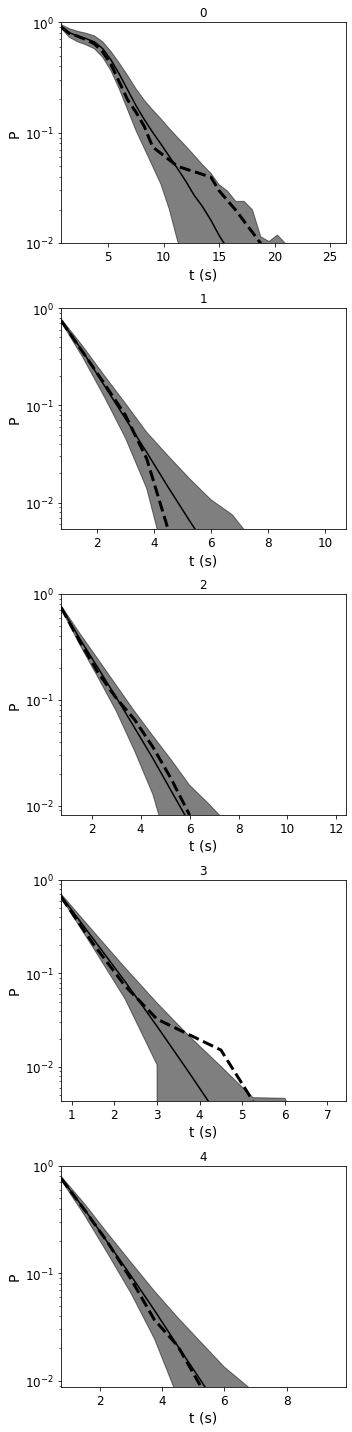

10
0.016949152542372836 0.00028232636928282595
[9.75, 32.25]
0.006514657980456029 9.90523457182757e-05
[6.0, 9.0]
0.0014204545454545303 8.10903566300647e-05
[7.5, 12.75]
0.005235602094240825 0.00017543859649127302
[3.75, 6.75]
0.015350877192982467 9.23872875091547e-05
[3.75, 7.5]


<Figure size 432x288 with 0 Axes>

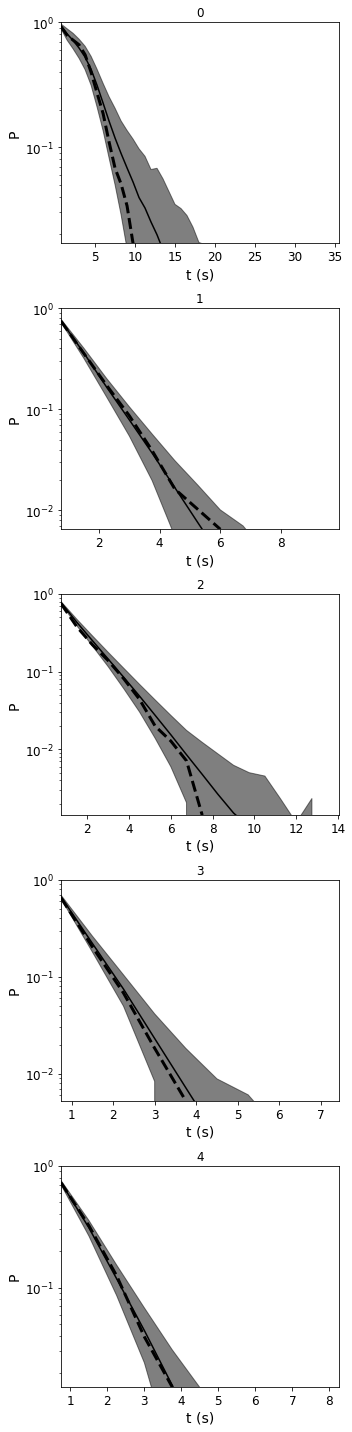

11


<Figure size 432x288 with 0 Axes>

In [14]:
n_states = 5
for worm in worms:
    plot_timescales(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay,colored=False)
#     plt.savefig('tscales_{}_states_worm_{}.pdf'.format(n_states,worm))
    plt.show()
    plt.clf()
    print(worm)

In [15]:
from scipy.stats import ks_2samp

worm = 0
n_states = 2
ks_state_w = np.zeros((len(worms),n_states,2))
for worm in worms:
    x_sim_state,y_sim_state,sims_lifetimes,data_lifetimes = get_lifetimes(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay)
    for state_idx in range(n_states):
        sim_lt = np.hstack([sims_lifetimes[k][state_idx] for k in range(len(sims_lifetimes))])
        data_lt = data_lifetimes[state_idx]
        ks_state_w[worm,state_idx] = ks_2samp(sim_lt,data_lt)

In [16]:
n_states = 5
ks_5states_w = np.zeros((len(worms),n_states,2))
for worm in worms:
    x_sim_state,y_sim_state,sims_lifetimes,data_lifetimes = get_lifetimes(worm,n_states,ensemble_labels_w,sims_w,labels_tree,delay)
    for state_idx in range(n_states):
        try:
            sim_lt = np.hstack([sims_lifetimes[k][state_idx] for k in range(len(sims_lifetimes))])
            data_lt = data_lifetimes[state_idx]

            ks_5states_w[worm,state_idx] = ks_2samp(sim_lt,data_lt)
        except:
            print('Could not compute for worm {} and state {}'.format(worm,state_idx))

In [17]:
def box_plot(x,y,std=.1,c='k'):
    plt.plot(np.linspace(-.2,.2,2)+x,[np.percentile(y,5)]*2,c='gray',lw=2)
    plt.plot(np.linspace(-.2,.2,2)+x,[np.percentile(y,95)]*2,c='gray',lw=2)
    plt.plot([x,x],[np.percentile(y,5),np.percentile(y,95)],c='gray',alpha=.5,lw=2)
    plt.plot(np.linspace(-.3,.3,2)+x,[np.median(y)]*2,c='k',lw=2.5)
    plt.scatter(np.zeros(len(y))+x+np.random.normal(0,std,len(y)),y,c=c,s=30)
    plt.scatter(x,np.median(y),s=30,facecolor="w",edgecolors='k',linewidths=1)


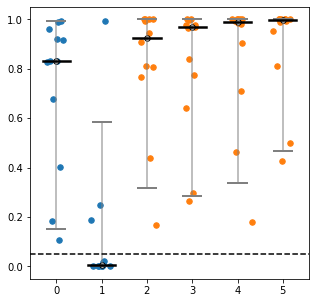

In [18]:
plt.figure(figsize=(5,5))
box_plot(0,ks_state_w[:,0,1],c=colors_state_[0])
box_plot(1,ks_state_w[:,1,1],c=colors_state_[0])

box_plot(2,ks_5states_w[:,1,1],c=colors_state_[1])
box_plot(3,ks_5states_w[:,2,1],c=colors_state_[1])
box_plot(4,ks_5states_w[:,3,1],c=colors_state_[1])
box_plot(5,ks_5states_w[:,4,1],c=colors_state_[1])

plt.axhline(0.05,ls='--',c='k')
# plt.savefig('p-values_all_states_scatter.pdf')

plt.show()